# Example

In this example, we will download ERA5 data for 1 Jan 2023 at $0.25\degree$ resolution and produce predictions using the non-fine-tuned version of Aurora $0.25\degree$.

To begin with, register an account with the [CDS](https://cds.climate.copernicus.eu/) and create `$HOME/.cdsapirc` with the following content:

You can find your UID and API key on your account page.

We now download the ERA5 data.

In [1]:
!pip install cdsapi

In [1]:
from pathlib import Path

import cdsapi

# Data will be downloaded here.
download_path = Path("~/downloads")

c = cdsapi.Client()

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables.
if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2023-01-01-surface-level.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "2m_temperature",
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "mean_sea_level_pressure",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-surface-level.nc"),
    )
print("Surface-level variables downloaded!")

# Download the atmospheric variables.
if not (download_path / "2023-01-01-atmospheric.nc").exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "temperature",
                "u_component_of_wind",
                "v_component_of_wind",
                "specific_humidity",
                "geopotential",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-atmospheric.nc"),
    )
print("Atmospheric variables downloaded!")

Static variables downloaded!
Surface-level variables downloaded!
Atmospheric variables downloaded!


In [2]:
from aurora import Aurora

import torch

model = Aurora(use_lora=False)  # Pretrained version does not use LoRA.
model.load_checkpoint("wbruinsma/aurora", "aurora-0.25-pretrained.ckpt")
model.eval()
model = model.to("cuda")

/home/wbruinsma/miniconda3/envs/aurora/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wbruinsma/aurora/aurora/model/aurora.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommen

In [3]:
!pip install xarray netcdf4

In [4]:
from aurora import Batch, Metadata

from datetime import datetime

import numpy as np
import torch
import xarray as xr

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / "2023-01-01-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / "2023-01-01-atmospheric.nc", engine="netcdf4")

surf_vars = {
    "2t": surf_vars_ds["t2m"].values[:2][None],
    "10u": surf_vars_ds["u10"].values[:2][None],
    "10v": surf_vars_ds["v10"].values[:2][None],
    "msl": surf_vars_ds["msl"].values[:2][None],
}
static_vars = {
    "z": static_vars_ds["z"].values[0],
    "slt": static_vars_ds["slt"].values[0],
    "lsm": static_vars_ds["lsm"].values[0],
}
atmos_vars = {
    "t": atmos_vars_ds["t"].values[:2][None],
    "u": atmos_vars_ds["u"].values[:2][None],
    "v": atmos_vars_ds["v"].values[:2][None],
    "q": atmos_vars_ds["q"].values[:2][None],
    "z": atmos_vars_ds["z"].values[:2][None],
}


def convert(variables: dict[str, np.ndarray]) -> dict[str, torch.Tensor]:
    """Convert the variables to PyTorch and move them to the GPU."""
    return {k: torch.tensor(v, dtype=torch.float32, device="cuda") for k, v in variables.items()}


batch = Batch(
    surf_vars=convert(surf_vars),
    static_vars=convert(static_vars),
    atmos_vars=convert(atmos_vars),
    metadata=Metadata(
        lat=torch.tensor(surf_vars_ds.latitude.values, dtype=torch.float32, device="cuda"),
        lon=torch.tensor(surf_vars_ds.longitude.values, dtype=torch.float32, device="cuda"),
        time=(datetime(2023, 1, 1, 6, 0),),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.level.values),
    ),
)

In [5]:
with torch.no_grad():
    pred = model(batch)

In [9]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 22.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.5 MB/s eta 0:00:00


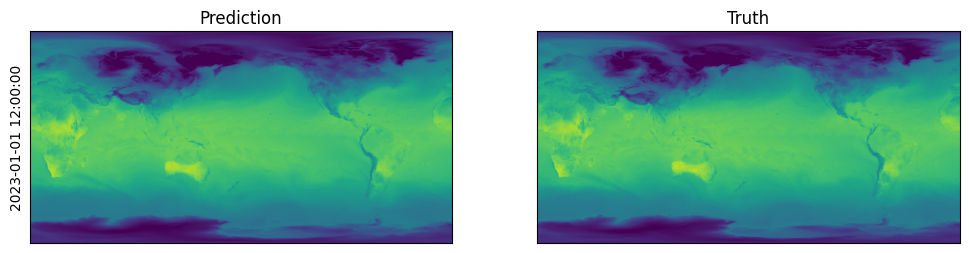

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(pred.surf_vars["2t"][0, 0].cpu().numpy() - 270, vmin=-30, vmax=50)
ax[0].set_ylabel(str(pred.metadata.time[0]))
ax[0].set_title("Prediction")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(surf_vars_ds["t2m"][2].values - 270, vmin=-30, vmax=50)
ax[1].set_title("Truth")
ax[1].set_xticks([])
ax[1].set_yticks([]);